In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt


test 1-3 are duplicated runs with the same random seed

In [2]:
emb1 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test1_rd_0_base.npy'))
lambdas1 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test1_rd_0_base.csv')
emb2 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test2_rd_0_base.npy'))
lambdas2 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test2_rd_0_base.csv')
emb3 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test3_rd_0_base.npy'))
lambdas3 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test3_rd_0_base.csv')

print(f'test1: shape of emb: {emb1.shape}, shape of lambdas: {lambdas1.shape}')
print(f'test2 shape of emb: {emb2.shape}, shape of lambdas: {lambdas2.shape}')
print(f'test3: shape of emb: {emb3.shape}, shape of lambdas: {lambdas3.shape}')

data = [(emb1, lambdas1), (emb2, lambdas2), (emb3, lambdas3)]

test1: shape of emb: torch.Size([49078, 512]), shape of lambdas: (49078, 1)
test2 shape of emb: torch.Size([49078, 512]), shape of lambdas: (49078, 1)
test3: shape of emb: torch.Size([49078, 512]), shape of lambdas: (49078, 1)


In [4]:
class lambdaset(Dataset):
    def __init__(self, X_train, X_test, y_train, y_test, train=True):

        if train:
            self.x_data, self.y_data = X_train, y_train
        else:
            self.x_data, self.y_data = X_test, y_test
    
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i], i

    def __len__(self):
        return self.y_data.shape[0]

In [5]:
# Regression model
class RegressionHead(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 16),
            nn.LeakyReLU(),

            nn.Linear(16, 1),
            nn.Softplus()  # non-negative lambda, sigmoid + cross entropy loss + clip = True?
        )
    
    def forward(self, x):
        return self.model(x)

In [6]:
# Regression model - # non-negative lambda according to min-max transformation of target variable -> sigmoid + clip
class RegressionHead2(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.clip_min = 1e-4
        self.clip_max = 1
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),

            nn.Linear(256, 16),
            nn.ReLU(),

            nn.Linear(16, 1),
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        x = torch.clamp(x, min=self.clip_min, max=self.clip_max)
        return x

In [21]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [28]:
def train_reinitialization(data):
    dic_train = {}
    dic_val = {}
    
    for run in range(0, len(data)):
        X = data[run][0]
        y = torch.tensor(data[run][1].values, dtype=torch.float32)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1357)
        scaler = MinMaxScaler()
        y_train = scaler.fit_transform(y_train.reshape(-1, 1)) 
        y_test = scaler.transform(y_test.reshape(-1, 1)) 
        
        train_loader = DataLoader(lambdaset(X_train, X_test, y_train, y_test, train = True), batch_size=128, shuffle=True, drop_last=True)
        val_loader = DataLoader(lambdaset(X_train, X_test, y_train, y_test, train = False), batch_size=128, shuffle=True, drop_last=True)
        
        model = RegressionHead(input_dim=X.shape[1])
        
        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3) 
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.95)
        
        
        # train and validation mse per batch
        train_mse_ls = []
        val_mse_ls = [] 
            
        # Training loop
        print(f'Run{run+1}')
        for epoch in range(100):
            model.train()
            total_loss = 0
            train_iterator = iter(train_loader)
            mse = []
            print_every = 10
            for j in range(len(train_loader)):
                x, y, i = next(train_iterator)
                optimizer.zero_grad()
                preds = model(x).squeeze()
                loss = criterion(preds, y.squeeze().float())
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                mse.append(mean_squared_error(y.squeeze().numpy(), preds.detach().numpy()))
            scheduler.step()
        
            batch_mse = sum(mse) / len(mse)    
            train_mse_ls.append(batch_mse)
                
            model.eval()
            val_iterator = iter(val_loader)
            val_mse = 0
            with torch.no_grad():
                for k in range(len(val_loader)):
                    x, y, i = next(val_iterator)
                    pred = model(x).squeeze()
                    val_mse += F.mse_loss(pred.squeeze(), y.squeeze())
                val_mse_ls.append(val_mse/len(val_loader))                
            
            if epoch % print_every == 0:
                print(f"Epoch {epoch+1} | training MSE: {batch_mse:.6f} | validation MSE: {val_mse_ls[-1]:.6f}") # mse on transformed scale
        dic_train['run'+str(run+1)] = train_mse_ls
        dic_val['run'+str(run+1)] = val_mse_ls
    return dic_train, dic_val

In [24]:
def train_no_reinitialization(data, model):
    dic_train = {}
    dic_val = {}
    
    for run in range(0, len(data)):
        X = data[run][0]
        y = torch.tensor(data[run][1].values, dtype=torch.float32)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1357)
        scaler = MinMaxScaler()
        y_train = scaler.fit_transform(y_train.reshape(-1, 1)) 
        y_test = scaler.transform(y_test.reshape(-1, 1)) 
        
        train_loader = DataLoader(lambdaset(X_train, X_test, y_train, y_test, train = True), batch_size=128, shuffle=True, drop_last=True)
        val_loader = DataLoader(lambdaset(X_train, X_test, y_train, y_test, train = False), batch_size=128, shuffle=True, drop_last=True)
        
        # model = RegressionHead(input_dim=X.shape[1])
        
        # Loss and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3) 
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.95)
        
        
        # train and validation mse per batch
        train_mse_ls = []
        val_mse_ls = [] 
            
        # Training loop
        print(f'Run{run+1}')
        for epoch in range(100):
            model.train()
            total_loss = 0
            train_iterator = iter(train_loader)
            mse = []
            print_every = 10
            for j in range(len(train_loader)):
                x, y, i = next(train_iterator)
                optimizer.zero_grad()
                preds = model(x).squeeze()
                loss = criterion(preds, y.squeeze().float())
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                mse.append(mean_squared_error(y.squeeze().numpy(), preds.detach().numpy()))
            scheduler.step()
        
            batch_mse = sum(mse) / len(mse)    
            train_mse_ls.append(batch_mse)
                
            model.eval()
            val_iterator = iter(val_loader)
            val_mse = 0
            with torch.no_grad():
                for k in range(len(val_loader)):
                    x, y, i = next(val_iterator)
                    pred = model(x).squeeze()
                    val_mse += F.mse_loss(pred.squeeze(), y.squeeze())
                val_mse_ls.append(val_mse/len(val_loader))
                
            if epoch % print_every == 0:
                print(f"Epoch {epoch+1} | training MSE: {batch_mse:.6f} | validation MSE: {val_mse_ls[-1]:.6f}") # mse on transformed scale
        dic_train['run'+str(run+1)] = train_mse_ls
        dic_val['run'+str(run+1)] = val_mse_ls
    return dic_train, dic_val

KeyError: 'run2'

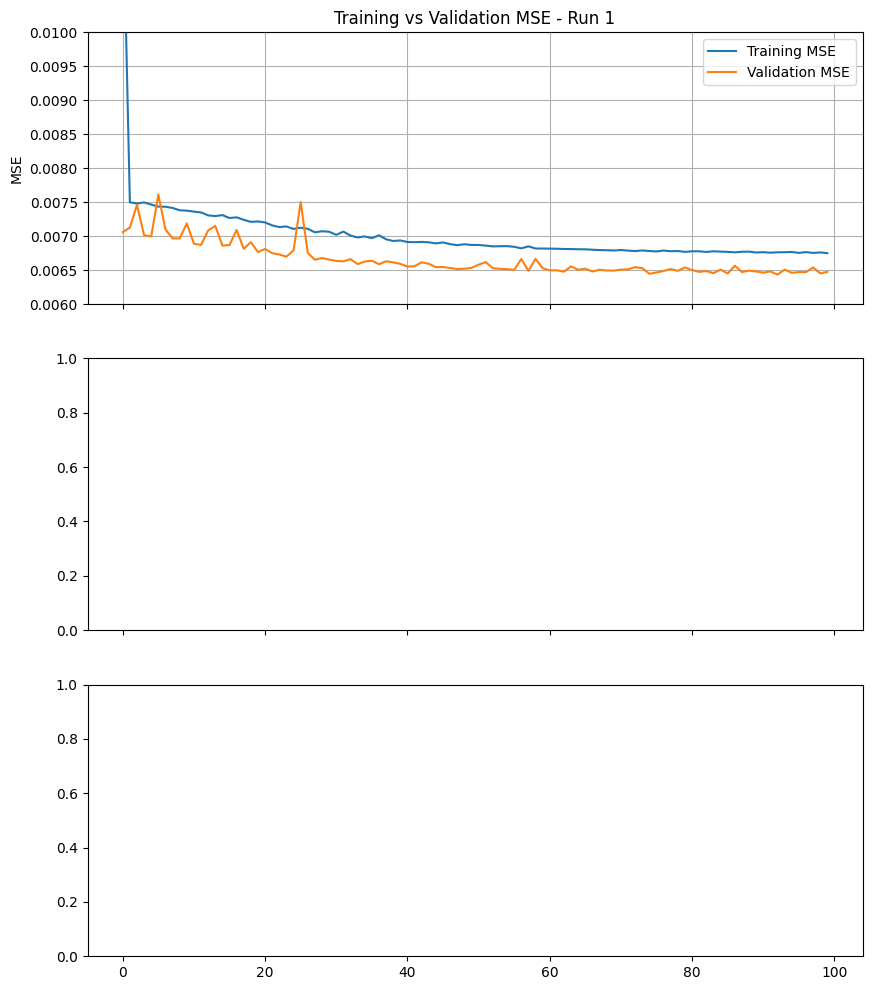

In [14]:
epochs = range(100)

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for i in range(3):
    axes[i].plot(epochs, dic_train['run'+str(i+1)], label='Training MSE')
    axes[i].plot(epochs, dic_val['run'+str(i+1)], label='Validation MSE')
    axes[i].set_ylabel('MSE')
    axes[i].set_ylim(0.0060, 0.0100)
    axes[i].set_title(f'Training vs Validation MSE - Run {i+1}')
    axes[i].legend()
    axes[i].grid(True)

axes[2].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

In [8]:
emb1 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test1_rd_1_base.npy'))
lambdas1 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test1_rd_1_base.csv')
emb2 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test2_rd_1_base.npy'))
lambdas2 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test2_rd_1_base.csv')
emb3 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test3_rd_1_base.npy'))
lambdas3 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test3_rd_1_base.csv')

print(f'test1: shape of emb: {emb1.shape}, shape of lambdas: {lambdas1.shape}')
print(f'test2 shape of emb: {emb2.shape}, shape of lambdas: {lambdas2.shape}')
print(f'test3: shape of emb: {emb3.shape}, shape of lambdas: {lambdas3.shape}')

data = [(emb1, lambdas1), (emb2, lambdas2), (emb3, lambdas3)]

test1: shape of emb: torch.Size([59589, 512]), shape of lambdas: (59589, 1)
test2 shape of emb: torch.Size([59589, 512]), shape of lambdas: (59589, 1)
test3: shape of emb: torch.Size([59589, 512]), shape of lambdas: (59589, 1)


Run1
Epoch 1 | training MSE: 0.006106 | validation MSE: 0.002891
Epoch 11 | training MSE: 0.002492 | validation MSE: 0.002561
Epoch 21 | training MSE: 0.002439 | validation MSE: 0.002494
Epoch 31 | training MSE: 0.002384 | validation MSE: 0.002481
Epoch 41 | training MSE: 0.002360 | validation MSE: 0.002466
Epoch 51 | training MSE: 0.002329 | validation MSE: 0.002432
Epoch 61 | training MSE: 0.002318 | validation MSE: 0.002434
Epoch 71 | training MSE: 0.002309 | validation MSE: 0.002409
Epoch 81 | training MSE: 0.002302 | validation MSE: 0.002411
Epoch 91 | training MSE: 0.002300 | validation MSE: 0.002407
Run2
Epoch 1 | training MSE: 0.005314 | validation MSE: 0.003320
Epoch 11 | training MSE: 0.002818 | validation MSE: 0.003142
Epoch 21 | training MSE: 0.002754 | validation MSE: 0.002941
Epoch 31 | training MSE: 0.002717 | validation MSE: 0.002971
Epoch 41 | training MSE: 0.002680 | validation MSE: 0.002867
Epoch 51 | training MSE: 0.002648 | validation MSE: 0.002843
Epoch 61 | train

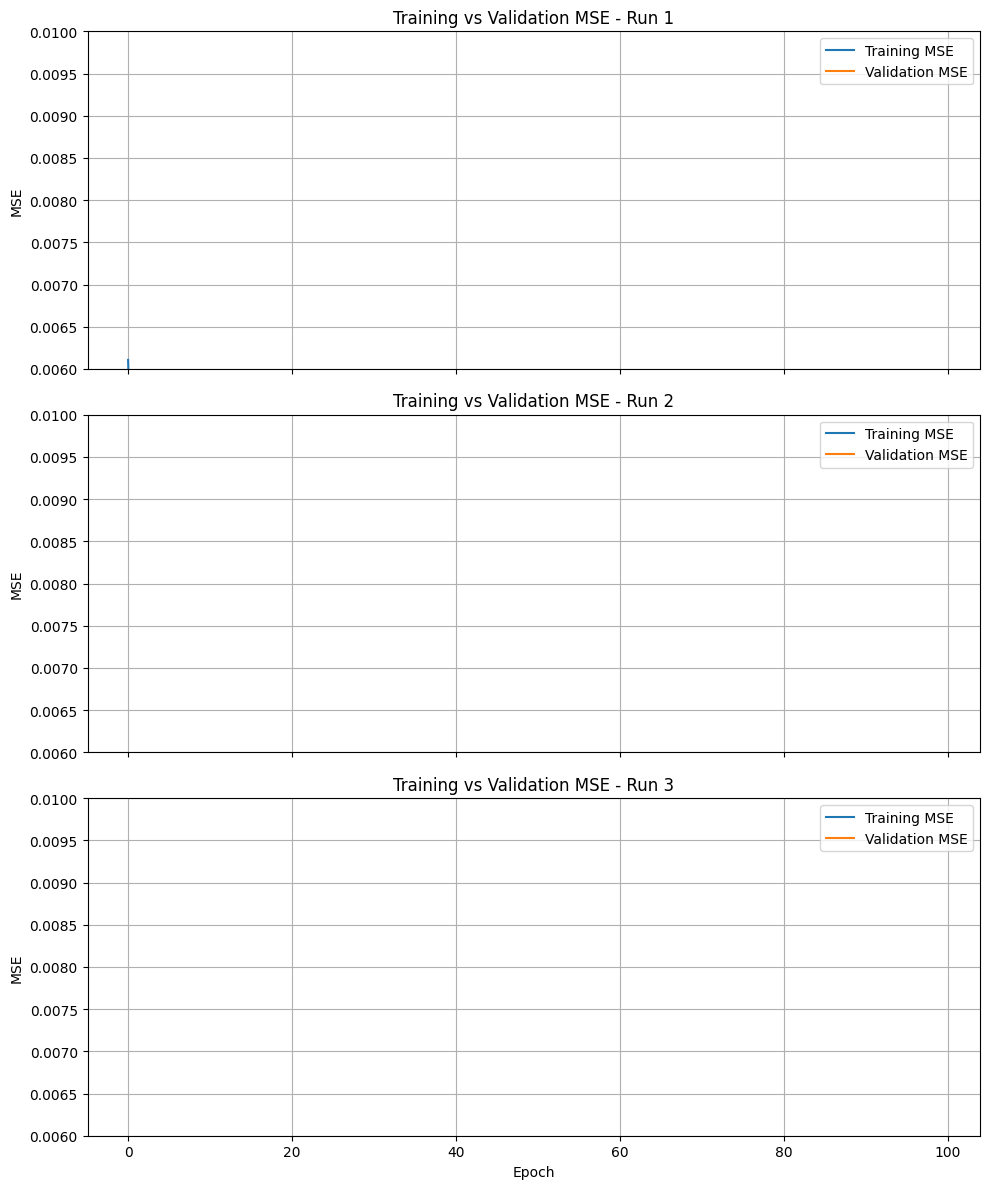

In [11]:
dic_train, dic_val = train(data)


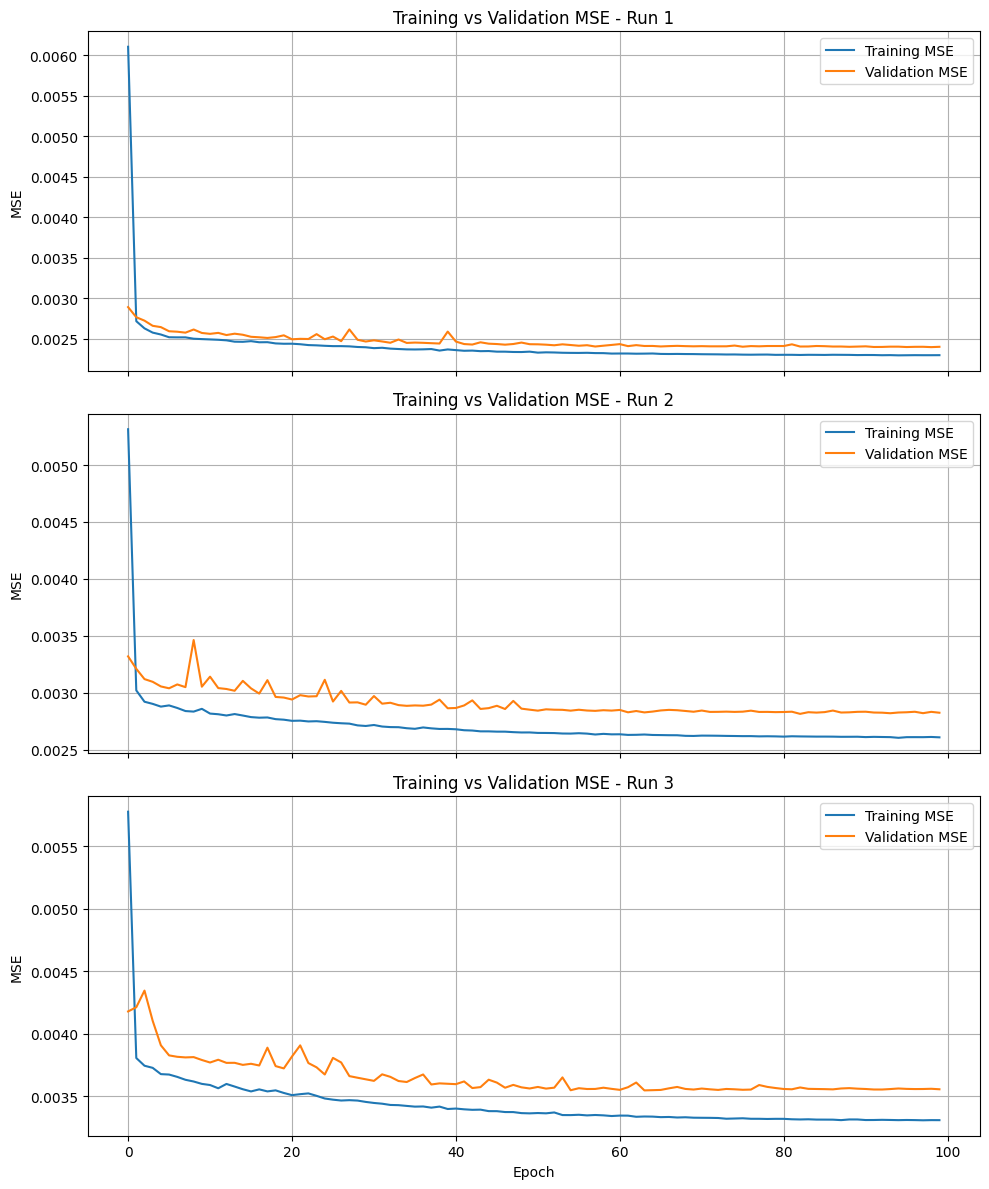

In [12]:

epochs = range(100)

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for i in range(3):
    axes[i].plot(epochs, dic_train['run'+str(i+1)], label='Training MSE')
    axes[i].plot(epochs, dic_val['run'+str(i+1)], label='Validation MSE')
    axes[i].set_ylabel('MSE')
    axes[i].set_title(f'Training vs Validation MSE - Run {i+1}')
    axes[i].legend()
    axes[i].grid(True)

axes[2].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

In [13]:
emb1 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test1_rd_2_base.npy'))
lambdas1 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test1_rd_2_base.csv')
emb2 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test2_rd_2_base.npy'))
lambdas2 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test2_rd_2_base.csv')
emb3 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test3_rd_2_base.npy'))
lambdas3 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test3_rd_2_base.csv')

print(f'test1: shape of emb: {emb1.shape}, shape of lambdas: {lambdas1.shape}')
print(f'test2 shape of emb: {emb2.shape}, shape of lambdas: {lambdas2.shape}')
print(f'test3: shape of emb: {emb3.shape}, shape of lambdas: {lambdas3.shape}')

data = [(emb1, lambdas1), (emb2, lambdas2), (emb3, lambdas3)]

test1: shape of emb: torch.Size([69408, 512]), shape of lambdas: (69408, 1)
test2 shape of emb: torch.Size([69408, 512]), shape of lambdas: (69408, 1)
test3: shape of emb: torch.Size([69408, 512]), shape of lambdas: (69408, 1)


Run1
Epoch 1 | training MSE: 0.012838 | validation MSE: 0.005986
Epoch 11 | training MSE: 0.005290 | validation MSE: 0.005563
Epoch 21 | training MSE: 0.005128 | validation MSE: 0.005545
Epoch 31 | training MSE: 0.005000 | validation MSE: 0.005544
Epoch 41 | training MSE: 0.004915 | validation MSE: 0.005515
Epoch 51 | training MSE: 0.004830 | validation MSE: 0.005560
Epoch 61 | training MSE: 0.004772 | validation MSE: 0.005512
Epoch 71 | training MSE: 0.004728 | validation MSE: 0.005534
Epoch 81 | training MSE: 0.004698 | validation MSE: 0.005548
Epoch 91 | training MSE: 0.004681 | validation MSE: 0.005521
Run2
Epoch 1 | training MSE: 0.012457 | validation MSE: 0.009951
Epoch 11 | training MSE: 0.008682 | validation MSE: 0.009289
Epoch 21 | training MSE: 0.008345 | validation MSE: 0.009452
Epoch 31 | training MSE: 0.008093 | validation MSE: 0.009197
Epoch 41 | training MSE: 0.007848 | validation MSE: 0.009226
Epoch 51 | training MSE: 0.007692 | validation MSE: 0.009333
Epoch 61 | train

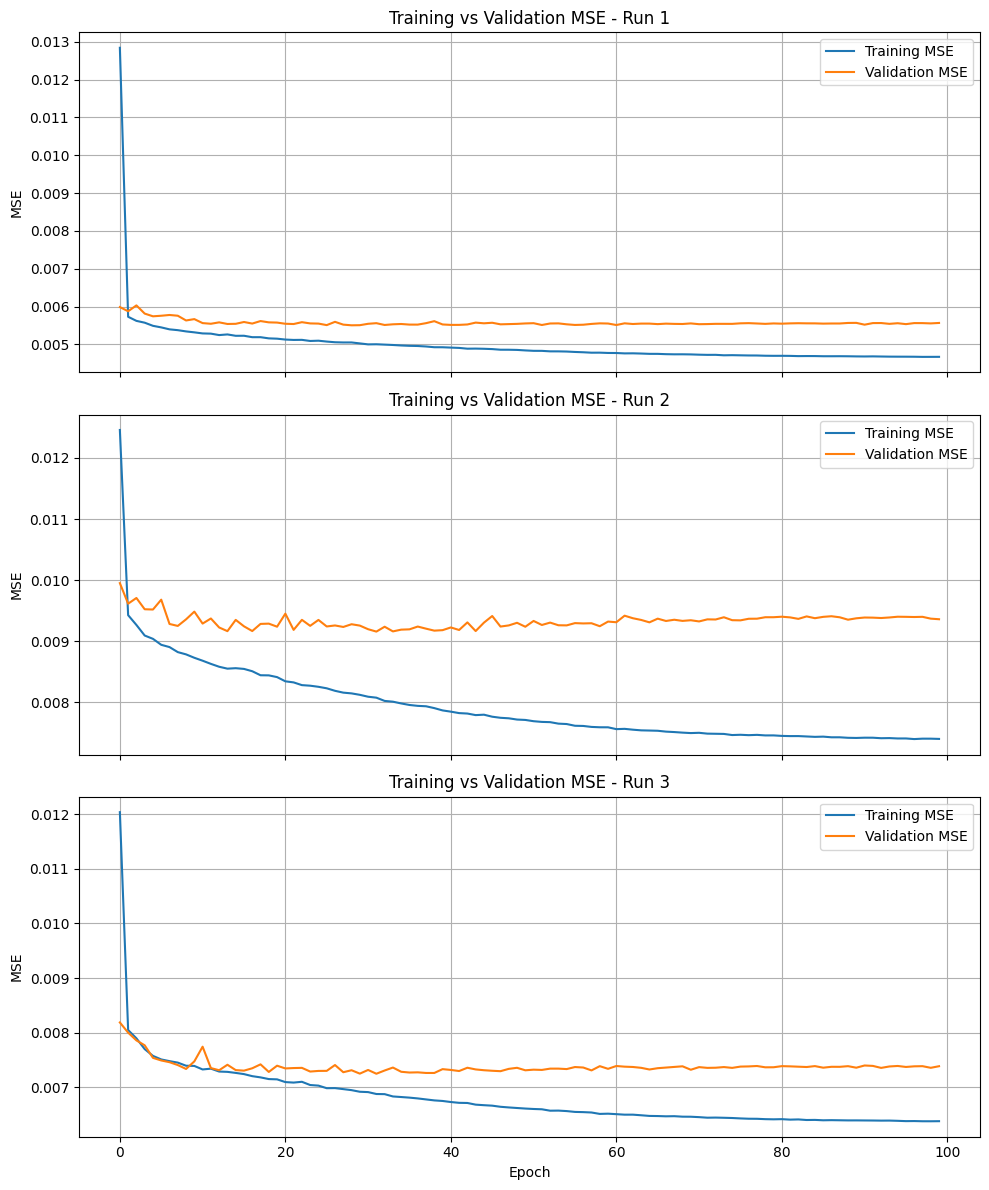

In [14]:
dic_train, dic_val = train(data)

epochs = range(100)

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for i in range(3):
    axes[i].plot(epochs, dic_train['run'+str(i+1)], label='Training MSE')
    axes[i].plot(epochs, dic_val['run'+str(i+1)], label='Validation MSE')
    axes[i].set_ylabel('MSE')
    axes[i].set_title(f'Training vs Validation MSE - Run {i+1}')
    axes[i].legend()
    axes[i].grid(True)

axes[2].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

Run1
Epoch 1 | training MSE: 0.013370 | validation MSE: 0.007319
Epoch 11 | training MSE: 0.007481 | validation MSE: 0.007013
Epoch 21 | training MSE: 0.007314 | validation MSE: 0.006878
Epoch 31 | training MSE: 0.007139 | validation MSE: 0.006730
Epoch 41 | training MSE: 0.007001 | validation MSE: 0.006662
Epoch 51 | training MSE: 0.006954 | validation MSE: 0.006647
Epoch 61 | training MSE: 0.006919 | validation MSE: 0.006634
Epoch 71 | training MSE: 0.006880 | validation MSE: 0.006575
Epoch 81 | training MSE: 0.006861 | validation MSE: 0.006589
Epoch 91 | training MSE: 0.006857 | validation MSE: 0.006563
Run2
Epoch 1 | training MSE: 0.009663 | validation MSE: 0.009360
Epoch 11 | training MSE: 0.002463 | validation MSE: 0.002601
Epoch 21 | training MSE: 0.002417 | validation MSE: 0.002561
Epoch 31 | training MSE: 0.002377 | validation MSE: 0.002627
Epoch 41 | training MSE: 0.002353 | validation MSE: 0.002515
Epoch 51 | training MSE: 0.002334 | validation MSE: 0.002508
Epoch 61 | train

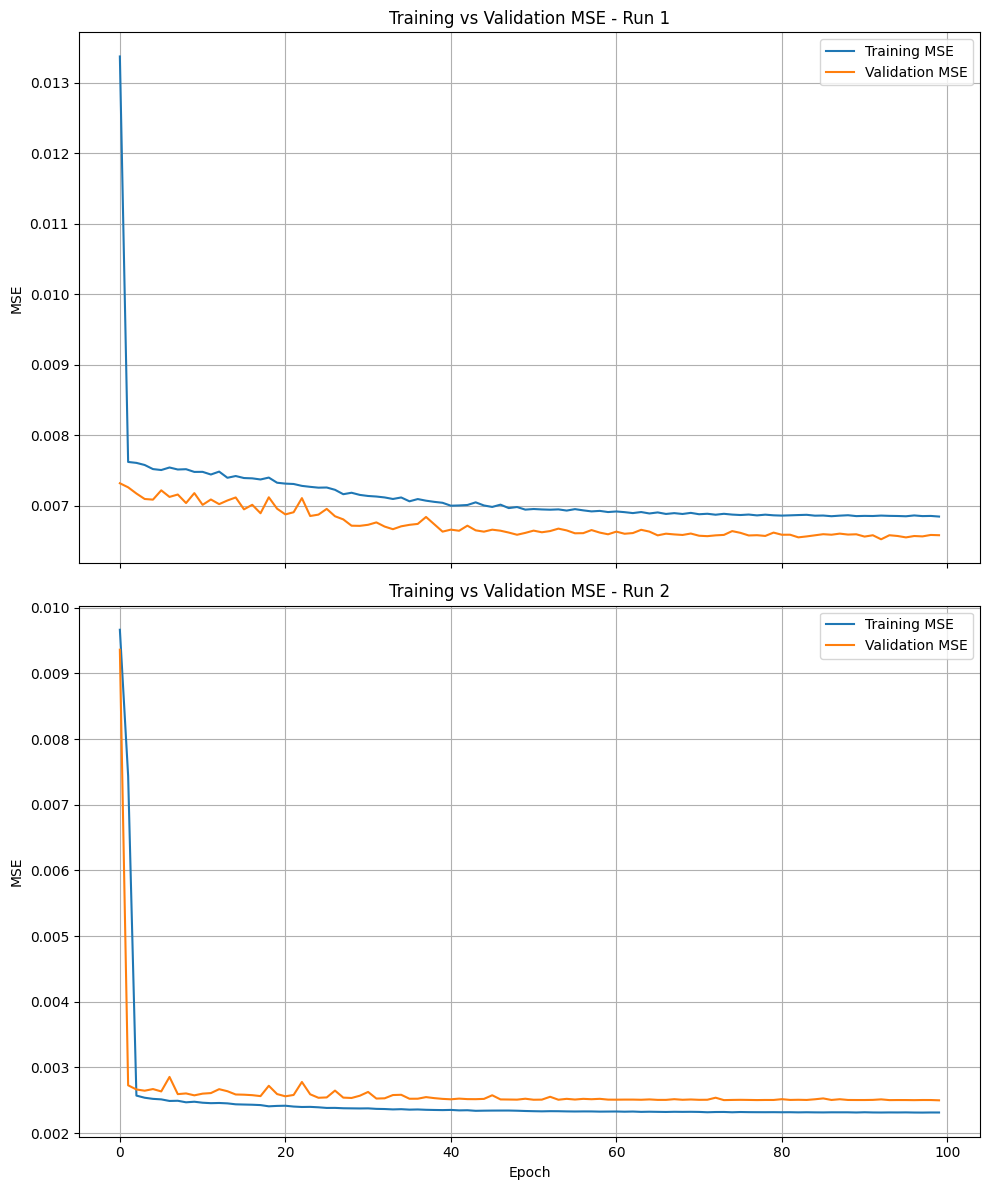

In [25]:
# add constraint relaxation

emb4_rd0 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test4_rd_0_base.npy'))
lambdas4_rd0 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test4_rd_0_base.csv')

emb4_rd1 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test4_rd_1_base.npy'))
lambdas4_rd1 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test4_rd_1_base.csv')

data = [(emb4_rd0, lambdas4_rd0), (emb4_rd1, lambdas4_rd1)]

model = RegressionHead(input_dim=data[0][0].shape[1])
dic_train, dic_val = train_no_reinitialization(data, model)

epochs = range(100)

fig, axes = plt.subplots(len(data), 1, figsize=(10, 12), sharex=True)

for i in range(len(data)):
    axes[i].plot(epochs, dic_train['run'+str(i+1)], label='Training MSE')
    axes[i].plot(epochs, dic_val['run'+str(i+1)], label='Validation MSE')
    axes[i].set_ylabel('MSE')
    axes[i].set_title(f'Training vs Validation MSE - Run {i+1}')
    axes[i].legend()
    axes[i].grid(True)

axes[len(data)-1].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

Run1
Epoch 1 | training MSE: 0.011855 | validation MSE: 0.007238
Epoch 11 | training MSE: 0.007447 | validation MSE: 0.007694
Epoch 21 | training MSE: 0.007295 | validation MSE: 0.006840
Epoch 31 | training MSE: 0.007163 | validation MSE: 0.006737
Epoch 41 | training MSE: 0.007022 | validation MSE: 0.006691
Epoch 51 | training MSE: 0.006967 | validation MSE: 0.006631
Epoch 61 | training MSE: 0.006909 | validation MSE: 0.006598
Epoch 71 | training MSE: 0.006896 | validation MSE: 0.006582
Epoch 81 | training MSE: 0.006879 | validation MSE: 0.006582
Epoch 91 | training MSE: 0.006859 | validation MSE: 0.006588
Run2
Epoch 1 | training MSE: 0.007447 | validation MSE: 0.003049
Epoch 11 | training MSE: 0.002522 | validation MSE: 0.002658
Epoch 21 | training MSE: 0.002436 | validation MSE: 0.002584
Epoch 31 | training MSE: 0.002404 | validation MSE: 0.002592
Epoch 41 | training MSE: 0.002368 | validation MSE: 0.002532
Epoch 51 | training MSE: 0.002348 | validation MSE: 0.002544
Epoch 61 | train

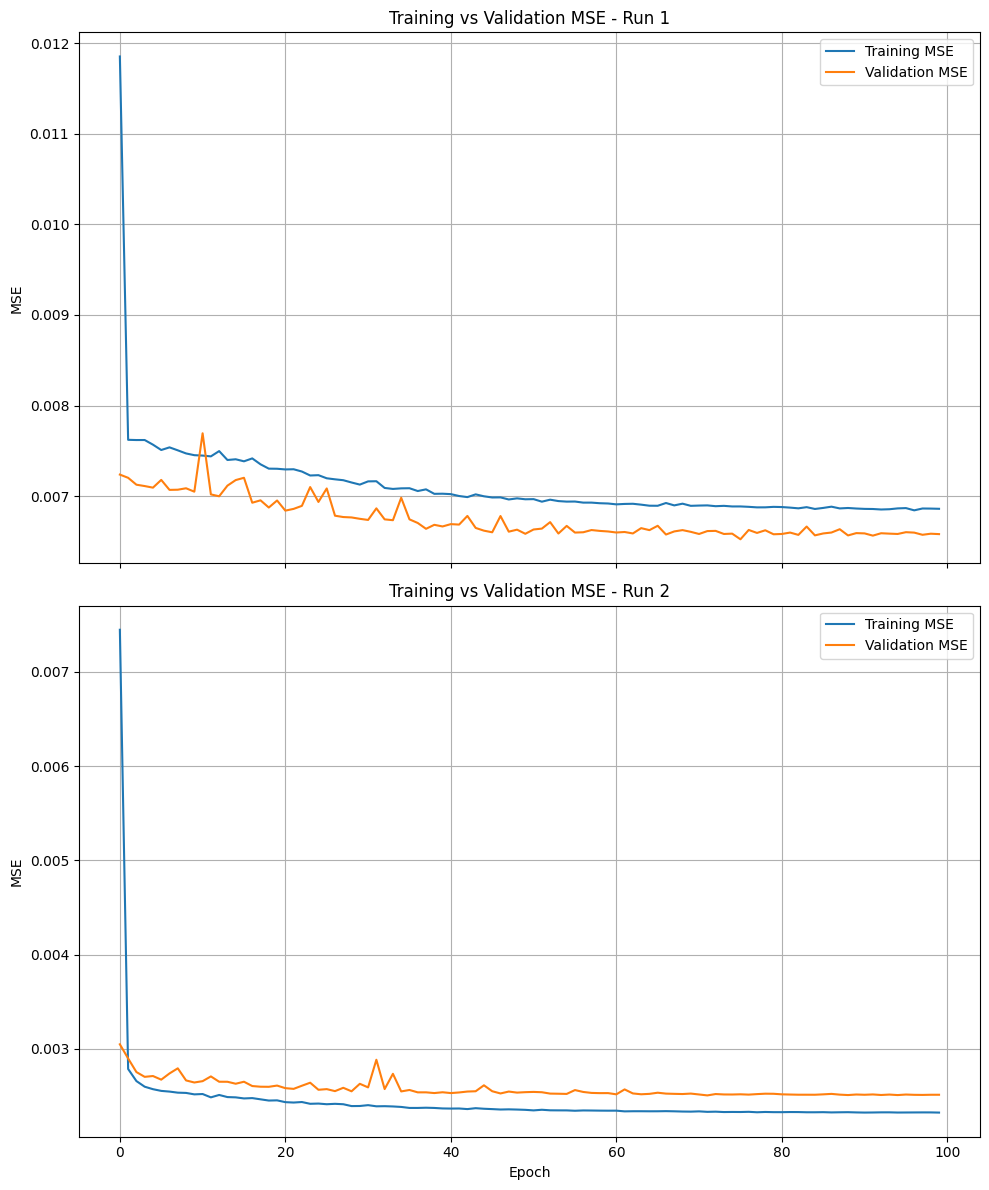

In [29]:
# add constraint relaxation

emb4_rd0 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test4_rd_0_base.npy'))
lambdas4_rd0 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test4_rd_0_base.csv')

emb4_rd1 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test4_rd_1_base.npy'))
lambdas4_rd1 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test4_rd_1_base.csv')

data = [(emb4_rd0, lambdas4_rd0), (emb4_rd1, lambdas4_rd1)]

dic_train, dic_val = train_reinitialization(data)

epochs = range(100)

fig, axes = plt.subplots(len(data), 1, figsize=(10, 12), sharex=True)

for i in range(len(data)):
    axes[i].plot(epochs, dic_train['run'+str(i+1)], label='Training MSE')
    axes[i].plot(epochs, dic_val['run'+str(i+1)], label='Validation MSE')
    axes[i].set_ylabel('MSE')
    axes[i].set_title(f'Training vs Validation MSE - Run {i+1}')
    axes[i].legend()
    axes[i].grid(True)

axes[len(data)-1].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

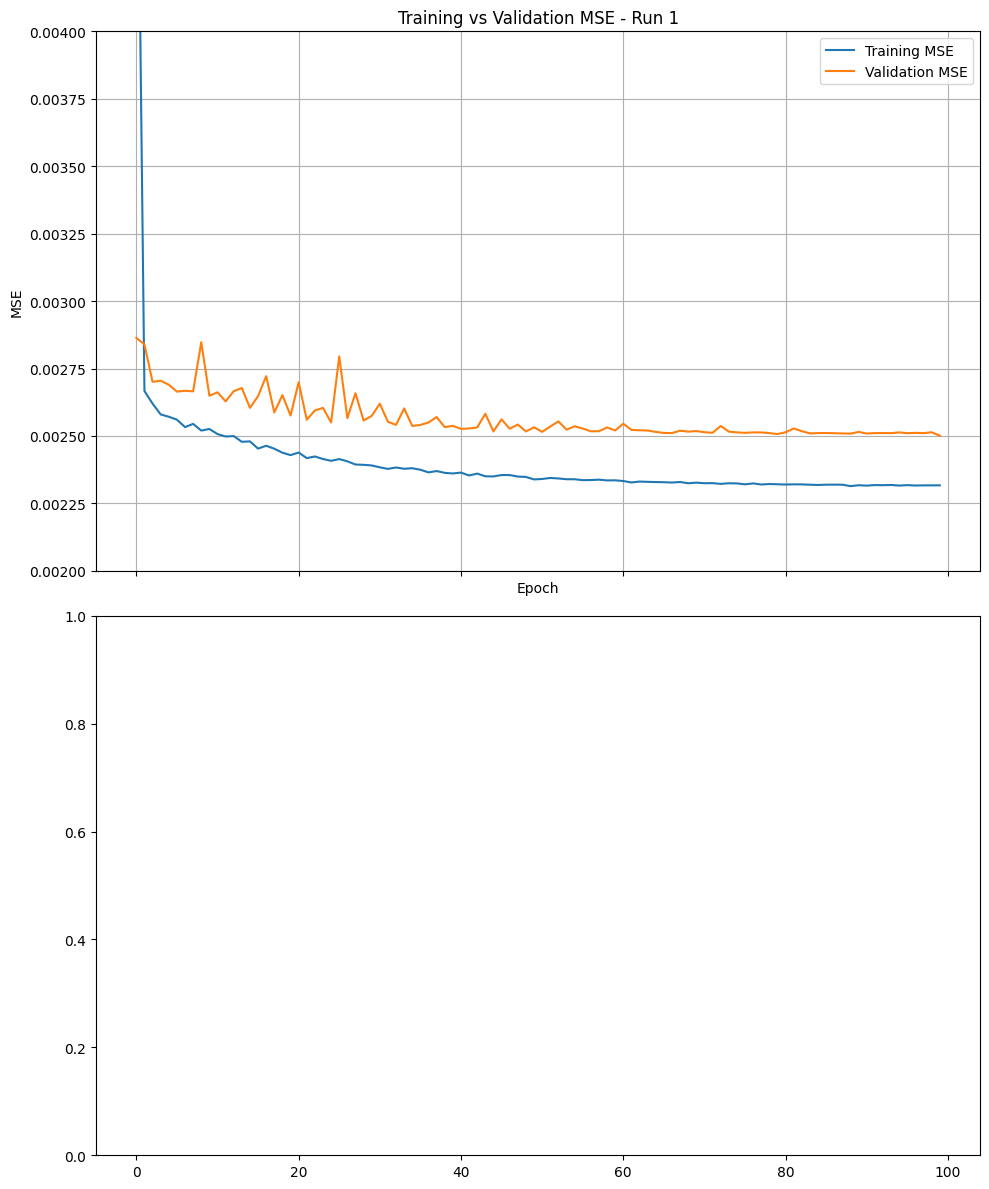

In [19]:
epochs = range(100)

fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

for i in range(len(data)):
    axes[i].plot(epochs, dic_train['run'+str(i+1)], label='Training MSE')
    axes[i].plot(epochs, dic_val['run'+str(i+1)], label='Validation MSE')
    axes[i].set_ylabel('MSE')
    axes[i].set_title(f'Training vs Validation MSE - Run {i+1}')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].set_ylim(0.0020, 0.0040)


axes[len(data)-1].set_xlabel('Epoch')

plt.tight_layout()
plt.show()